# YAASS Dataset

#### The dataset below includes demographic information and multiple clinical measures taken in 3 populations: healthy controls, those at clinical high risk for psychosis, and those at familial high risk.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [2]:
%cd {path2code}

import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests

/Users/ebarrick/Work/Expts/Code


array(['vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex', 'reshape2',
       'effsize', 'lsmeans', 'estimability', 'lmerTest', 'lme4', 'Matrix',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='|S12')

In [38]:
#Function to assign names to disorders in FAME dataset
def dx_name(data):
    d = {0:'None', 1:'MDD', 2:'Anxiety', 3:'Sub_abuse', 4:'ADHD', 
         5:'Eating', 6:'Schizotypal', 7:'2_co', 8: '3_co', 9:'4_co','999':'na'}
    dx = d[data]
    return dx 

raw_sh = pd.read_excel(path2data + 'Bx_Paper_YAASS_Feb2017_edit.xlsx')
raw_sh['Gender'].replace(2, 'female', inplace=True)
raw_sh['Gender'].replace(1,'male', inplace=True)

raw_sz = pd.read_excel(path2data + 'SCORE Data_Bx_IRI_SocialFx.xlsx')
raw_sz['Group'].replace(2, 'SZ', inplace=True)
raw_sz['Gender'].replace(1,'male',inplace=True)
raw_sz['Gender'].replace(2,'female',inplace=True)

raw_fhr = pd.read_excel(path2data + 'FAME_Neuropsych_NEW_edit.xlsx')
raw_fhr['Group'].replace(1, 'FHR', inplace=True)
raw_fhr['Gender'].replace(2, 'female', inplace=True)
raw_fhr['Gender'].replace(1,'male', inplace=True)

g = raw_fhr.append(raw_sz)

raw = g.append(raw_sh)
pd.set_option('display.max_columns', 500)

In [40]:
raw.to_csv('raw.csv')

In [39]:
#Function for creating a new column of z scores from existing column
cols = raw[['IRI_EC','IRI_FS','IRI_PD','IRI_PT']]

for col in cols:
    col_zscore = col + '_z'
    raw[col_zscore] = (raw[col] - raw[col].mean())/raw[col].std(ddof=0)

raw.head()

,Age,Chapman_MIS,Chapman_PAS,Chapman_PhAS,Chapman_RTS,Chapman_SocAnh,DAS,DSMDisorder,DSMDisorderType,DSMcomorbidities,Education,Ethnicity,GFS_Role,GFS_Social,Gender,Group,ID,IQ,IRI_EC,IRI_FS,IRI_PD,IRI_PT,IRI_Total,Medication,PANAS_NA,PANAS_PA,SIPS_Disorganized,SIPS_GAF,SIPS_General,SIPS_Negative,SIPS_Positive,SIPS_mean,SocAdjScale_SocialLeisure,SocAdjScale_Work,IRI_EC_z,IRI_FS_z,IRI_PD_z,IRI_PT_z
0,25,NaN,NaN,NaN,NaN,NaN,NaN,1,7,2,14,NaN,NaN,NaN,female,FHR,2501,99,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0.75,70,0.75,0.500000,1.4,0.842105,NaN,NaN,NaN,NaN,NaN,NaN
1,29,7,1,5,1,2,NaN,1,7,2,16,NaN,NaN,NaN,female,FHR,2504,118,21,6,6,23,NaN,1,NaN,NaN,0.50,80,0.50,0.333333,1.0,0.578947,1.2,1.5,-1.090216,-2.448663,-1.583995,-0.877474
2,33,1,1,2,0,11,NaN,0,0,0,14,NaN,NaN,NaN,male,FHR,2505,95,21,19,5,24,NaN,0,NaN,NaN,0.25,84,0.00,0.000000,0.4,0.157895,1.9,1.5,-1.090216,-0.751952,-1.722555,-0.718590
3,33,4,9,11,5,24,NaN,1,4,1,13,NaN,NaN,NaN,male,FHR,2506,109,14,15,9,23,NaN,0,NaN,NaN,1.00,63,0.75,1.166667,1.2,1.052632,1.8,1.4,-2.079279,-1.274017,-1.168314,-0.877474
4,28,4,1,8,0,9,NaN,0,NaN,0,16,NaN,NaN,NaN,male,FHR,2508,118,18,16,16,23,NaN,1,NaN,NaN,1.25,70,1.00,0.500000,1.4,1.000000,1.3,1.7,-1.514100,-1.143500,-0.198393,-0.877474


### Demographics

In [6]:
raw.groupby('Group')['ID'].nunique()

Group
FHR    19
HC     24
HR     27
SZ     26
Name: ID, dtype: int64

In [7]:
#Even split in HC group, more males in HR and SZ group - unsurprising...however mostly female in GHR group

raw.groupby('Group')['Gender'].value_counts()

Group        
FHR    female    14
       male       5
HC     male      12
       female    12
HR     male      18
       female     9
SZ     male      16
       female    10
dtype: int64

Group       
FHR    count    19.000000
       mean     27.421053
       std       3.920258
       min      20.000000
       25%      24.500000
       50%      27.000000
       75%      31.000000
       max      33.000000
HC     count    24.000000
       mean     22.750000
       std       4.002716
       min      18.000000
       25%      19.750000
       50%      22.000000
       75%      24.750000
       max      33.000000
HR     count    27.000000
       mean     21.629630
       std       4.404090
       min      15.000000
       25%      18.000000
       50%      22.000000
       75%      23.500000
       max      34.000000
SZ     count    26.000000
       mean     38.692308
       std      10.279180
       min      21.000000
       25%      31.250000
       50%      38.500000
       75%      44.750000
       max      58.000000
dtype: float64


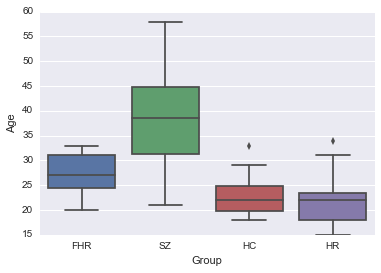

In [8]:
#Age
g=raw.groupby('Group')
print (g.Age.describe())

sns.boxplot(x='Group',y='Age',data=raw)

In [9]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

Group       
FHR    count     18.000000
       mean     117.000000
       std        9.779931
       min       95.000000
       25%      115.500000
       50%      118.000000
       75%      121.750000
       max      136.000000
HC     count     24.000000
       mean     115.125000
       std       10.330674
       min       97.000000
       25%      107.750000
       50%      117.500000
       75%      119.000000
       max      138.000000
HR     count     24.000000
       mean     106.791667
       std       17.688068
       min       79.000000
       25%       91.750000
       50%      106.500000
       75%      122.250000
       max      139.000000
SZ     count     26.000000
       mean     108.076923
       std       13.323432
       min       82.000000
       25%       99.000000
       50%      107.500000
       75%      118.750000
       max      133.000000
dtype: float64
Between group t-test on IQ HC and HR
t(46) = 1.99, p = 0.052, g = 0.575
Between group t-test on IQ HC and SZ

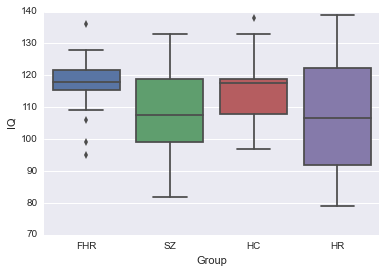

In [10]:
#IQ: Looks like FHR has significantly higher IQ than HC (and therefore all groups)

i = raw_IQ.groupby('Group')

print (i.IQ.describe())
print ('Between group t-test on IQ HC and HR')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'HR']['IQ'])

print ('Between group t-test on IQ HC and SZ')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'SZ']['IQ'])

print ('Between group t-test on IQ HC and FHR')
misc.ttest_2s(raw_IQ[raw_IQ.Group == 'HC']['IQ'],raw_IQ[raw_IQ.Group == 'FHR']['IQ'])

sns.boxplot(x='Group',y='IQ',data=raw_IQ)

### Data Quality Check

In [11]:
#Dataframe where any row that has NAN value is dropped- will tell us how many participants have at least some missing 
#data
sh_no_na = raw_sh.dropna()

In [12]:
# looks like most participants have some missing values...
sh_no_na.groupby('Group')['ID'].nunique()

Group
HC    15
HR    19
Name: ID, dtype: int64

In [13]:
#Dataframe where any row that has less than 6 entries - which corresponds to anything other than demographic 
#information/subject ID entered - are dropped. These are participants that should not be included in the analyses.
df_cleaned = raw.dropna(thresh=6)

In [14]:
#one participant that has no measures taken: 26195
df_cleaned.groupby('Group')['ID'].nunique()

Group
FHR    19
HC     24
HR     26
SZ     26
Name: ID, dtype: int64

### Looking at Measures

In [51]:
raw2 = pd.read_csv('/Users/ebarrick/Desktop/raw.csv')
raw2.head()

,Unnamed: 0,Age,Chapman_MIS,Chapman_PAS,Chapman_PhAS,Chapman_RTS,Chapman_SocAnh,DAS,DSMDisorder,DSMDisorderType,DSMcomorbidities,Education,Ethnicity,GFS_Role,GFS_Social,Gender,Group,ID,IQ,IRI_EC,IRI_FS,IRI_PD,IRI_PT,IRI_Total,Medication,PANAS_NA,PANAS_PA,SIPS_Disorganized,SIPS_GAF,SIPS_General,SIPS_Negative,SIPS_Positive,SIPS_mean,SocAdjScale_SocialLeisure,SocAdjScale_Work,IRI_EC_z,IRI_FS_z,IRI_PD_z,IRI_PT_z,IRI_EC_z_S,IRI_FS_z_S,IRI_PD_z_S,IRI_PT_z_S
0,0,25,NaN,NaN,NaN,NaN,NaN,NaN,1,7,2,14,NaN,NaN,NaN,female,FHR,2501,99,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,0.75,70,0.75,0.500000,1.4,0.842105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,29,7,1,5,1,2,NaN,1,7,2,16,NaN,NaN,NaN,female,FHR,2504,118,21,6,6,23,NaN,1,NaN,NaN,0.50,80,0.50,0.333333,1.0,0.578947,1.2,1.5,-1.090216,-2.448663,-1.583995,-0.877474,-1.08400,-2.43471,-1.57497,-0.87247
2,2,33,1,1,2,0,11,NaN,0,0,0,14,NaN,NaN,NaN,male,FHR,2505,95,21,19,5,24,NaN,0,NaN,NaN,0.25,84,0.00,0.000000,0.4,0.157895,1.9,1.5,-1.090216,-0.751952,-1.722555,-0.718590,-1.08400,-0.74767,-1.71274,-0.71449
3,3,33,4,9,11,5,24,NaN,1,4,1,13,NaN,NaN,NaN,male,FHR,2506,109,14,15,9,23,NaN,0,NaN,NaN,1.00,63,0.75,1.166667,1.2,1.052632,1.8,1.4,-2.079279,-1.274017,-1.168314,-0.877474,-2.06743,-1.26676,-1.16166,-0.87247
4,4,28,4,1,8,0,9,NaN,0,NaN,0,16,NaN,NaN,NaN,male,FHR,2508,118,18,16,16,23,NaN,1,NaN,NaN,1.25,70,1.00,0.500000,1.4,1.000000,1.3,1.7,-1.514100,-1.143500,-0.198393,-0.877474,-1.50547,-1.13698,-0.19726,-0.87247


                                Age        IQ  IRI_EC_z  IRI_FS_z  IRI_PD_z  \
Age                        1.000000 -0.154927  0.238793  0.116967 -0.190443   
IQ                        -0.154927  1.000000 -0.418537 -0.680313 -0.635044   
IRI_EC_z                   0.238793 -0.418537  1.000000  0.638750  0.289604   
IRI_FS_z                   0.116967 -0.680313  0.638750  1.000000  0.694452   
IRI_PD_z                  -0.190443 -0.635044  0.289604  0.694452  1.000000   
IRI_PT_z                   0.304245 -0.382115  0.927911  0.597433  0.208887   
SIPS_Disorganized         -0.368005 -0.604079 -0.036717  0.548503  0.726483   
SIPS_Negative             -0.223689 -0.681399 -0.058065  0.538575  0.748033   
SIPS_Positive             -0.169036 -0.684830  0.087440  0.674944  0.789235   
SIPS_General              -0.345745 -0.521651 -0.114337  0.486425  0.763813   
SocAdjScale_SocialLeisure -0.201565 -0.706985  0.410019  0.803895  0.898316   
SocAdjScale_Work          -0.509318 -0.575220  0.370

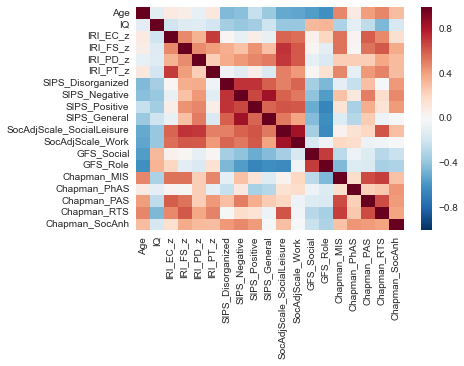

In [31]:
corr = raw[['Age','IQ','Group','Gender','IRI_EC_z','IRI_FS_z','IRI_PD_z','IRI_PT_z','SIPS_Disorganized','SIPS_Negative',
            'SIPS_Positive', 'SIPS_General','SocAdjScale_SocialLeisure','SocAdjScale_Work','GFS_Social','GFS_Role',
            'Chapman_MIS','Chapman_PhAS','Chapman_PAS','Chapman_RTS','Chapman_SocAnh']].corr()
print corr.corr()

sns.heatmap(corr)

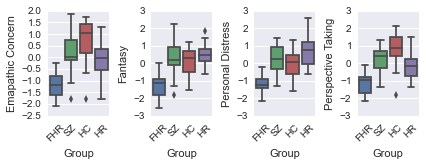

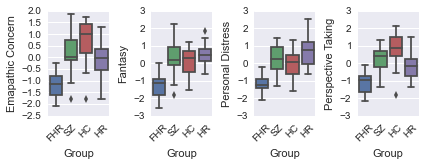

In [52]:
# Need to standardize the scoring
#FHR scored on a 5 point scale - HR, HC, and SZ on a 6 point scale

fig = plt.figure()
iri = fig.add_subplot(241)
sns.boxplot(y='IRI_EC_z', x='Group', data = raw)
plt.ylabel('Emapathic Concern')
plt.xticks(rotation=45)
iri = fig.add_subplot(242)
sns.boxplot(y='IRI_FS_z', x='Group', data = raw)
plt.ylabel('Fantasy')
plt.xticks(rotation=45)
iri = fig.add_subplot(243)
sns.boxplot(y='IRI_PD_z', x='Group', data = raw)
plt.ylabel('Personal Distress')
plt.xticks(rotation=45)
iri = fig.add_subplot(244)
sns.boxplot(y='IRI_PT_z', x='Group', data = raw)
plt.ylabel('Perspective Taking')
plt.xticks(rotation=45)
fig.tight_layout()

#SPSS

fig = plt.figure()
iri = fig.add_subplot(245)
sns.boxplot(y='IRI_EC_z_S', x='Group', data = raw2)
plt.ylabel('Emapathic Concern')
plt.xticks(rotation=45)
iri = fig.add_subplot(246)
sns.boxplot(y='IRI_FS_z_S', x='Group', data = raw2)
plt.ylabel('Fantasy')
plt.xticks(rotation=45)
iri = fig.add_subplot(247)
sns.boxplot(y='IRI_PD_z_S', x='Group', data = raw2)
plt.ylabel('Personal Distress')
plt.xticks(rotation=45)
iri = fig.add_subplot(248)
sns.boxplot(y='IRI_PT_z_S', x='Group', data = raw2)
plt.ylabel('Perspective Taking')
plt.xticks(rotation=45)
fig.tight_layout()

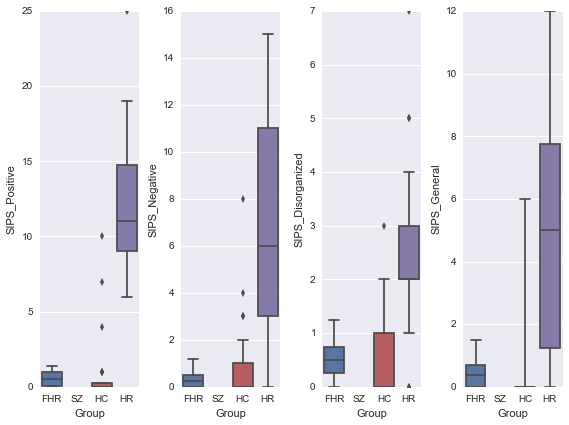

In [17]:
fig = plt.figure(figsize=(8, 6))
iri = fig.add_subplot(141)
sns.boxplot(y='SIPS_Positive', x='Group', data = raw)
iri = fig.add_subplot(142)
sns.boxplot(y='SIPS_Negative', x='Group', data = raw)
iri = fig.add_subplot(143)
sns.boxplot(y='SIPS_Disorganized', x='Group', data = raw)
iri = fig.add_subplot(144)
sns.boxplot(y='SIPS_General', x='Group', data = raw)
fig.tight_layout()

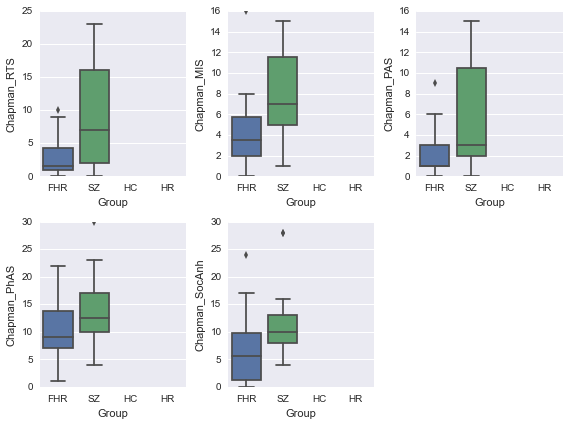

In [18]:
fig = plt.figure(figsize=(8, 6))
iri = fig.add_subplot(231)
sns.boxplot(y='Chapman_RTS', x='Group', data = raw)
iri = fig.add_subplot(232)
sns.boxplot(y='Chapman_MIS', x='Group', data = raw)
iri = fig.add_subplot(233)
sns.boxplot(y='Chapman_PAS', x='Group', data = raw)
iri = fig.add_subplot(234)
sns.boxplot(y='Chapman_PhAS', x='Group', data = raw)
iri = fig.add_subplot(235)
sns.boxplot(y='Chapman_SocAnh', x='Group', data = raw)
fig.tight_layout()

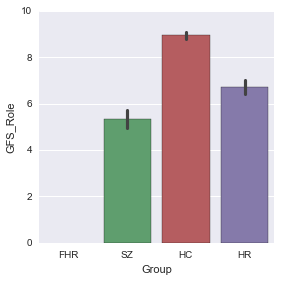

In [19]:
sns.factorplot(y='GFS_Role',x='Group',units='ID',ci=68,kind='bar',data=raw)

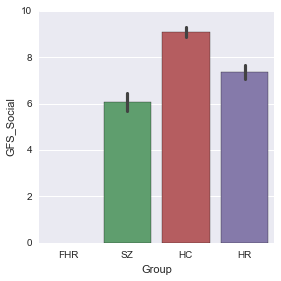

In [20]:
sns.factorplot(y='GFS_Social',x='Group',units='ID',ci=68,kind='bar',data=raw)

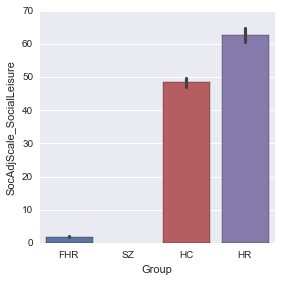

In [21]:
sns.factorplot(y='SocAdjScale_SocialLeisure',x='Group',units='ID',ci=68,kind='bar',data=raw)

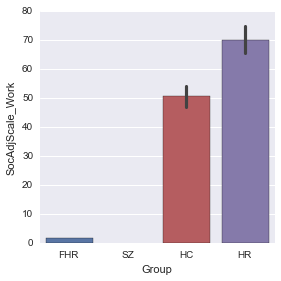

In [22]:
sns.factorplot(y='SocAdjScale_Work',x='Group',units='ID',ci=68,kind='bar',data=raw)